# How good are we at temporal reconstruction?

## Load the data

In [1]:
import sys
sys.path.append('..')
import dependencies
import soft_dependencies

Python Version 3.9.12 (main, Jun  1 2022, 06:36:29) 
[Clang 12.0.0 ]
Numpy Version 1.22.2
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Pandas Version 1.4.2
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.animation import FuncAnimation, PillowWriter
from PIL import Image
import glob
from sklearn.decomposition import PCA

In [14]:
from Scripts.antGLasso import antGLasso, antGLasso_heuristic
from Scripts.anBiGLasso import calculate_empirical_covariances
from Scripts.EiGLasso import EiGLasso_cov
from Scripts.nonparanormal_skeptic import nonparanormal_tensor_skeptic, nonparanormal_skeptic

In [7]:
np.set_printoptions(precision=3, suppress=True)
%load_ext line_profiler
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


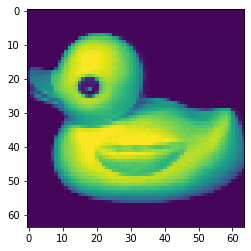

In [5]:
# Here we load the image, and optionally drop every `imsize_factor`th pixel
# if we want to minimize pixels.  In the BiGLasso paper, they considered 9 by 9
# We consider the 64x64 case
import glob
imsize_factor = 2
imsize = 128 // imsize_factor
files = sorted(glob.glob('../../Data/coil-20-proc/*.png'))
duck_mat = np.array(
    [np.array(Image.open(f))[::imsize_factor, ::imsize_factor].reshape(imsize**2) for f in files],
    dtype=np.int16
).reshape((20, 72, imsize**2))
duck_mat.shape # object, frame, flattened pixel
plt.imshow(duck_mat[10, 0].reshape(imsize, imsize))

## Run code

(72, 4096)
(72, 4096)
(360, 4096)
(1800, 4096)


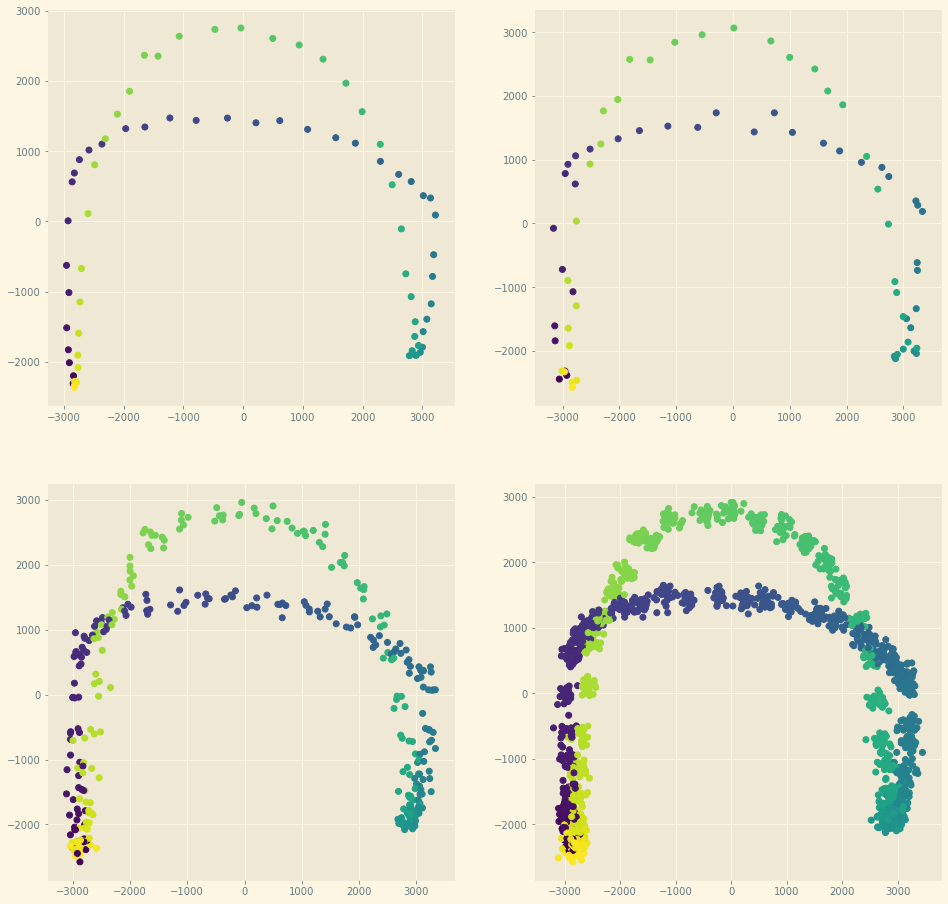

In [122]:
def generate_noisey_duck(num_duplications, noise_strength=300):
    noisy_duck_quack_quack = np.concatenate([
        duck_mat[10] + np.random.random(duck_mat[10].shape) * noise_strength
        for i in range(num_duplications)
    ])
    print(noisy_duck_quack_quack.shape)
    pcad_vals = PCA(n_components=2).fit_transform(noisy_duck_quack_quack).T
    colors = np.concatenate([np.arange(72) for i in range(num_duplications)])
    return noisy_duck_quack_quack, pcad_vals, colors
ducky_duck0, pcad_vals0, colors0 = generate_noisey_duck(1, noise_strength=1)
noisy_duck1, pcad_vals1, colors1 = generate_noisey_duck(1)
noisy_duck5, pcad_vals5, colors5 = generate_noisey_duck(5)
noisy_duck25, pcad_vals25, colors25 = generate_noisey_duck(25)
with plt.style.context('Solarize_Light2'):
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(figsize=(16, 16), ncols=2, nrows=2)
    ax0.scatter(*pcad_vals0, c=colors0)
    ax1.scatter(*pcad_vals1, c=colors1)
    ax2.scatter(*pcad_vals5, c=colors5)
    ax3.scatter(*pcad_vals25, c=colors25)

In [129]:
def plot_in_pca_space(ax, pcad_vals, Psi, colors):
    num_correct = 0
    num_dupes = pcad_vals.shape[1] // 72
    for idx, (x1, y1) in enumerate(pcad_vals.T):
        connections = np.abs(Psi[idx])
        connections[idx] = 0 # set diagonal to zero
        idx2 = connections.argmax()
        connections[idx2] = 0 # set to zero to find second largest connection
        idx3 = connections.argmax()
        x2, y2 = pcad_vals[:, idx2]
        ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.5), linewidth=3)
        x3, y3 = pcad_vals[:, idx3]
        ax.plot([x1, x3], [y1, y3], color=(1, 0, 0, 0.5), linewidth=3)
        if np.abs((idx // num_dupes) - (idx2 // num_dupes)) <= 1:
            # If connected to the same frame or the frame after/before it, count
            # it as correct (for largest connection)
            num_correct += 1
        if np.abs((idx // num_dupes) - (idx3 // num_dupes)) <= 1:
            # If connected to the same frame or the frame after/before it, count
            # it as correct (for second largest connection)
            num_correct += 1
    ax.scatter(*pcad_vals, c=colors)
    return (num_correct / pcad_vals.shape[1]) / 2

In [123]:
T, S = nonparanormal_skeptic(ducky_duck0[np.newaxis, ...])
Psi, Theta = antGLasso_heuristic([T, S], sparsities=[1, 1], B_approx_iters=1000)
precmat0_nonpara = np.abs(Psi)
precmat_neg0_nonpara = np.maximum(-Psi, 1e-10)
covmat0_nonpara = np.linalg.inv(Psi)

T, S = nonparanormal_skeptic(noisy_duck1[np.newaxis, ...])
Psi, Theta = antGLasso_heuristic([T, S], sparsities=[1, 1], B_approx_iters=1000)
precmat1_nonpara = np.abs(Psi)
precmat_neg1_nonpara = np.maximum(-Psi, 1e-10)
covmat1_nonpara = np.linalg.inv(Psi)

T, S = nonparanormal_skeptic(noisy_duck5[np.newaxis, ...])
Psi, Theta = antGLasso_heuristic([T, S], sparsities=[1, 1], B_approx_iters=1000)
precmat5_nonpara = np.abs(Psi)
precmat_neg5_nonpara = np.maximum(-Psi, 1e-10)
covmat5_nonpara = np.linalg.inv(Psi)

T, S = nonparanormal_skeptic(noisy_duck25[np.newaxis, ...])
Psi, Theta = antGLasso_heuristic([T, S], sparsities=[1, 1], B_approx_iters=1000)
precmat25_nonpara = np.abs(Psi)
precmat_neg25_nonpara = np.maximum(-Psi, 1e-10)
covmat25_nonpara = np.linalg.inv(Psi)

In [124]:
T, S = calculate_empirical_covariances(ducky_duck0[np.newaxis, ...])
Psi, Theta = antGLasso_heuristic([T, S], sparsities=[1, 1], B_approx_iters=1000)
precmat0_empirical = np.abs(Psi)
precmat_neg0_empirical = np.maximum(-Psi, 1e-10)
covmat0_empirical = np.linalg.inv(Psi)

T, S = calculate_empirical_covariances(noisy_duck1[np.newaxis, ...])
Psi, Theta = antGLasso_heuristic([T, S], sparsities=[1, 1], B_approx_iters=1000)
precmat1_empirical = np.abs(Psi)
precmat_neg1_empirical = np.maximum(-Psi, 1e-10)
covmat1_empirical = np.linalg.inv(Psi)

T, S = calculate_empirical_covariances(noisy_duck5[np.newaxis, ...])
Psi, Theta = antGLasso_heuristic([T, S], sparsities=[1, 1], B_approx_iters=1000)
precmat5_empirical = np.abs(Psi)
precmat_neg5_empirical = np.maximum(-Psi, 1e-10)
covmat5_empirical = np.linalg.inv(Psi)

T, S = calculate_empirical_covariances(noisy_duck25[np.newaxis, ...])
Psi, Theta = antGLasso_heuristic([T, S], sparsities=[1, 1], B_approx_iters=1000)
precmat25_empirical = np.abs(Psi)
precmat_neg25_empirical = np.maximum(-Psi, 1e-10)
covmat25_empirical = np.linalg.inv(Psi)

In [125]:
Psi, Theta = antGLasso(ducky_duck0[np.newaxis, ...], sparsities=[1, 1], B_approx_iters=1000)
precmat0_vanilla = np.abs(Psi)
precmat_neg0_vanilla = np.maximum(-Psi, 1e-10)
covmat0_vanilla = np.linalg.inv(Psi)

Psi, Theta = antGLasso(noisy_duck1[np.newaxis, ...], sparsities=[1, 1], B_approx_iters=1000)
precmat1_vanilla = np.abs(Psi)
precmat_neg1_vanilla = np.maximum(-Psi, 1e-10)
covmat1_vanilla = np.linalg.inv(Psi)

Psi, Theta = antGLasso(noisy_duck5[np.newaxis, ...], sparsities=[1, 1], B_approx_iters=1000)
precmat5_vanilla = np.abs(Psi)
precmat_neg5_vanilla = np.maximum(-Psi, 1e-10)
covmat5_vanilla = np.linalg.inv(Psi)

Psi, Theta = antGLasso(noisy_duck25[np.newaxis, ...], sparsities=[1, 1], B_approx_iters=1000)
precmat25_vanilla = np.abs(Psi)
precmat_neg25_vanilla = np.maximum(-Psi, 1e-10)
covmat25_vanilla = np.linalg.inv(Psi)

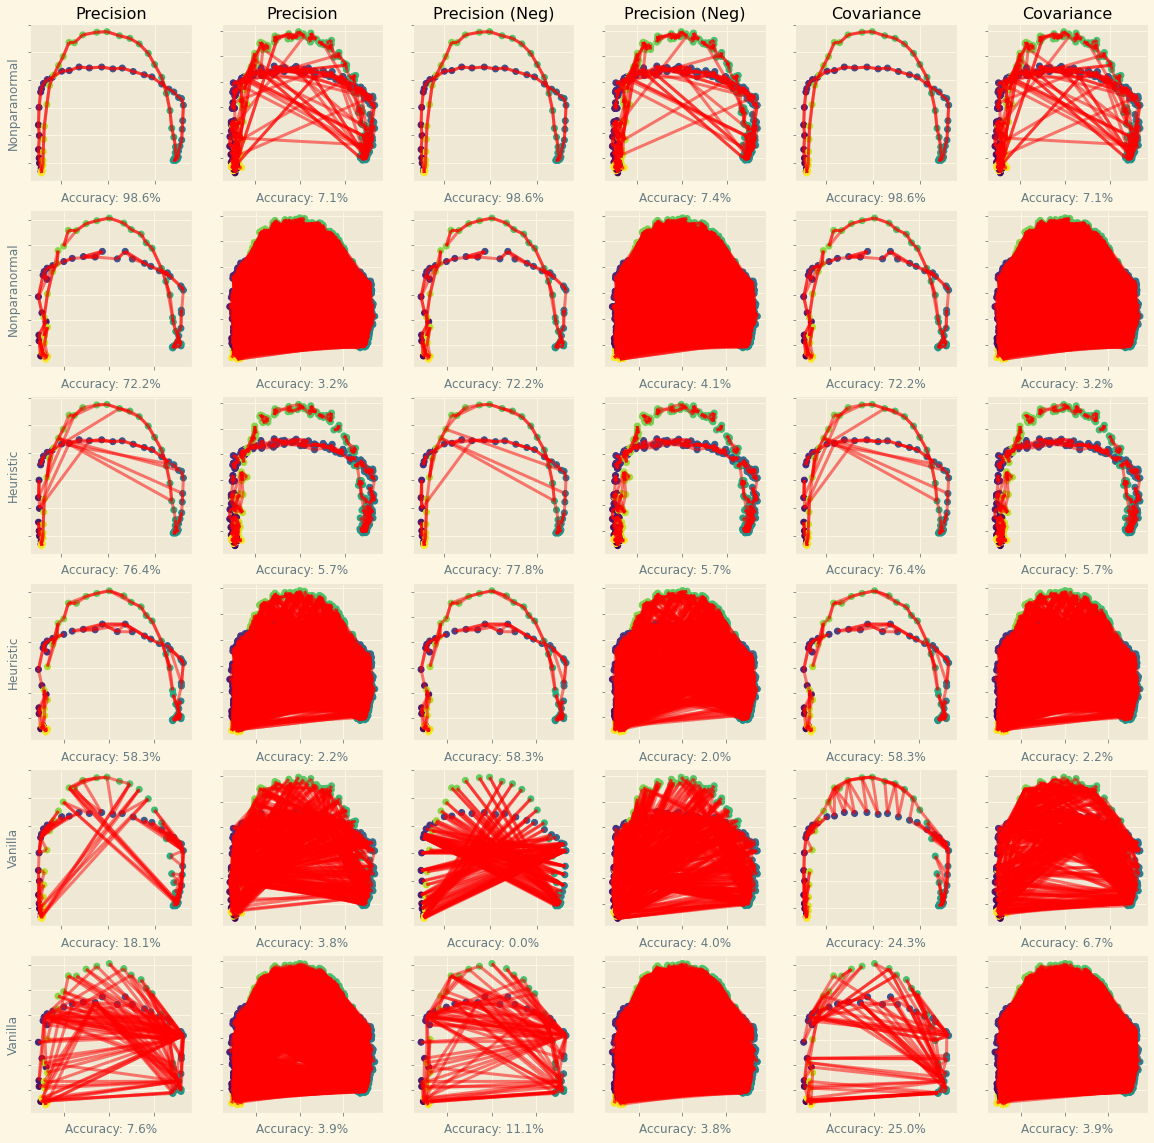

In [126]:
with plt.style.context("Solarize_Light2"):
    fig, axs = plt.subplots(figsize=(20, 20), nrows=6, ncols=6)
    for row in axs:
        for ax in row:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
    axs[0, 0].set_ylabel("Nonparanormal")
    axs[1, 0].set_ylabel("Nonparanormal")
    axs[2, 0].set_ylabel("Heuristic")
    axs[3, 0].set_ylabel("Heuristic")
    axs[4, 0].set_ylabel("Vanilla")
    axs[5, 0].set_ylabel("Vanilla")
    
    axs[0, 0].set_title("Precision")
    axs[0, 1].set_title("Precision")
    axs[0, 2].set_title("Precision (Neg)")
    axs[0, 3].set_title("Precision (Neg)")
    axs[0, 4].set_title("Covariance")
    axs[0, 5].set_title("Covariance")
    
    #===========================================================================
    c = plot_in_pca_space(axs[0, 0], pcad_vals0, precmat0_nonpara, colors0)
    axs[0, 0].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[0, 2], pcad_vals0, precmat_neg0_nonpara, colors0)
    axs[0, 2].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[0, 4], pcad_vals0, covmat0_nonpara, colors0)
    axs[0, 4].set_xlabel(f"Accuracy: {100*c:.1f}%")
    
    c = plot_in_pca_space(axs[1, 0], pcad_vals1, precmat1_nonpara, colors1)
    axs[1, 0].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[1, 2], pcad_vals1, precmat_neg1_nonpara, colors1)
    axs[1, 2].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[1, 4], pcad_vals1, covmat1_nonpara, colors1)
    axs[1, 4].set_xlabel(f"Accuracy: {100*c:.1f}%")
    
    c = plot_in_pca_space(axs[0, 1], pcad_vals5, precmat5_nonpara, colors5)
    axs[0, 1].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[0, 3], pcad_vals5, precmat_neg5_nonpara, colors5)
    axs[0, 3].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[0, 5], pcad_vals5, covmat5_nonpara, colors5)
    axs[0, 5].set_xlabel(f"Accuracy: {100*c:.1f}%")
    
    c = plot_in_pca_space(axs[1, 1], pcad_vals25, precmat25_nonpara, colors25)
    axs[1, 1].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[1, 3], pcad_vals25, precmat_neg25_nonpara, colors25)
    axs[1, 3].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[1, 5], pcad_vals25, covmat25_nonpara, colors25)
    axs[1, 5].set_xlabel(f"Accuracy: {100*c:.1f}%")
    #===========================================================================
    
    #===========================================================================
    c = plot_in_pca_space(axs[2, 0], pcad_vals0, precmat0_empirical, colors0)
    axs[2, 0].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[2, 2], pcad_vals0, precmat_neg0_empirical, colors0)
    axs[2, 2].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[2, 4], pcad_vals0, covmat0_empirical, colors0)
    axs[2, 4].set_xlabel(f"Accuracy: {100*c:.1f}%")
    
    c = plot_in_pca_space(axs[3, 0], pcad_vals1, precmat1_empirical, colors1)
    axs[3, 0].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[3, 2], pcad_vals1, precmat_neg1_empirical, colors1)
    axs[3, 2].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[3, 4], pcad_vals1, covmat1_empirical, colors1)
    axs[3, 4].set_xlabel(f"Accuracy: {100*c:.1f}%")
    
    c = plot_in_pca_space(axs[2, 1], pcad_vals5, precmat5_empirical, colors5)
    axs[2, 1].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[2, 3], pcad_vals5, precmat_neg5_empirical, colors5)
    axs[2, 3].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[2, 5], pcad_vals5, covmat5_empirical, colors5)
    axs[2, 5].set_xlabel(f"Accuracy: {100*c:.1f}%")
    
    c = plot_in_pca_space(axs[3, 1], pcad_vals25, precmat25_empirical, colors25)
    axs[3, 1].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[3, 3], pcad_vals25, precmat_neg25_empirical, colors25)
    axs[3, 3].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[3, 5], pcad_vals25, covmat25_empirical, colors25)
    axs[3, 5].set_xlabel(f"Accuracy: {100*c:.1f}%")
    #===========================================================================
    
    #===========================================================================
    c = plot_in_pca_space(axs[4, 0], pcad_vals0, precmat0_vanilla, colors0)
    axs[4, 0].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[4, 2], pcad_vals0, precmat_neg0_vanilla, colors0)
    axs[4, 2].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[4, 4], pcad_vals0, covmat0_vanilla, colors0)
    axs[4, 4].set_xlabel(f"Accuracy: {100*c:.1f}%")
    
    c = plot_in_pca_space(axs[5, 0], pcad_vals1, precmat1_vanilla, colors1)
    axs[5, 0].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[5, 2], pcad_vals1, precmat_neg1_vanilla, colors1)
    axs[5, 2].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[5, 4], pcad_vals1, covmat1_vanilla, colors1)
    axs[5, 4].set_xlabel(f"Accuracy: {100*c:.1f}%")
    
    c = plot_in_pca_space(axs[4, 1], pcad_vals5, precmat5_vanilla, colors5)
    axs[4, 1].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[4, 3], pcad_vals5, precmat_neg5_vanilla, colors5)
    axs[4, 3].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[4, 5], pcad_vals5, covmat5_vanilla, colors5)
    axs[4, 5].set_xlabel(f"Accuracy: {100*c:.1f}%")
    
    c = plot_in_pca_space(axs[5, 1], pcad_vals25, precmat25_vanilla, colors25)
    axs[5, 1].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[5, 3], pcad_vals25, precmat_neg25_vanilla, colors25)
    axs[5, 3].set_xlabel(f"Accuracy: {100*c:.1f}%")
    c = plot_in_pca_space(axs[5, 5], pcad_vals25, covmat25_vanilla, colors25)
    axs[5, 5].set_xlabel(f"Accuracy: {100*c:.1f}%")
    #===========================================================================

In [127]:
fig.savefig("../../Plots/Fundamental Barriers/Temporal Comparison", bbox_inches='tight')